In [1]:
import os
import pprint

import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from langchain_openai import ChatOpenAI

from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.docstore.document import Document

from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score

from sklearn.model_selection import train_test_split
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

## Few-Shot Calibration 

### Load TTPHunter Data  (For Calibration )

In [5]:
df1 = pd.read_csv('../DATA/TTPHunter_dataset.csv')
#print(df1.head())

train1, test1 = train_test_split(df1, test_size=0.2, random_state=0)
print(len(test1))

1678


In [6]:
df1.head()

,Domain,Technique ID,Technique Name,Sentences
0,Enterprise,T1543,Create or Modify System Process: Windows Service,Carbanak malware installs itself as a service ...
1,Enterprise,T1562,Impair Defenses: Disable or Modify System Fire...,Carbanak may use netsh to add local firewall r...
2,Enterprise,T1036,Masquerading: Masquerade Task or Service,Carbanak has copied legitimate service names t...
3,Enterprise,T1036,Masquerading: Match Legitimate Name or Location,"Carbanak has named malware ""svchost.exe,"" whic..."
4,Enterprise,T1588,Obtain Capabilities: Tool,Carbanak has obtained and used open-source too...


In [87]:
test1[["Technique ID", "Sentences"]]

,Technique ID,Sentences
6290,T1082,Unknown Logger can obtain information about th...
6326,T1036,Skidmap has created a fake rm binary to replac...
6494,T1012,Carberp has searched the Image File Execution ...
2632,T1056,FakeM contains a keylogger module.[1]
7128,T1113,ZxShell can capture screenshots.[1]
...,...,...
2152,T1059,SamSam uses custom batch scripts to execute so...
4127,T1041,GrimAgent has sent data related to a compromis...
4827,T1059,Bisonal has launched cmd.exe and used the Shel...
6518,T1036,The TrickBot downloader has used an icon to ap...


### Embeddings and DB

In [8]:
model = "ehsanaghaei/SecureBERT"
embeddings = HuggingFaceEmbeddings(model_name = model)

/tmp/ipykernel_2473875/3155946519.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  embeddings = HuggingFaceEmbeddings(model_name = model)
/home/hamzicd/.local/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
No sentence-transformers model found with name ehsanaghaei/SecureBERT. Creating a new one with mean pooling.
Some weights of RobertaModel were not initialized from the model checkpoint at ehsanaghaei/SecureBERT and are newly initialized: ['roberta.poo

In [9]:
# create documents from df rows
docs1 = []
for index, row in train1.iterrows():
    doc = Document(page_content=row["Sentences"], metadata={"TTP_ID": row["Technique ID"]})
    docs1.append(doc)

print(len(docs1))

6709


In [10]:
# init vector DB
db1 = FAISS.from_documents(docs1, embeddings)

### Few Shot Classification

In [11]:
llm1 = ChatOpenAI(model="gpt-4o", temperature=0)

In [15]:
### prompt builder
def build_prompt(text_to_predict, few_shot_number, database):
    ##### Prompt 1
    search_results = database.similarity_search_with_score(text_to_predict, k=few_shot_number)

    
    prompt = ["\nText:"+ doc.page_content.lower().strip()+"\nSimilarity:"+ str(score) +"\nClassification:"+doc.metadata['TTP_ID']+"\n" for doc, score in search_results if score < 20]
    

    prompt = ''.join(prompt)+"\nInputText:"+ text_to_predict.lower().strip() +"\nClassification:"
    prompt = """You are a MITRE ATT&CK TTP classification expert.
    Your task is to classify the 'InputText' based on the provided examples below.
    Each example shows:
    - a sentence (Text),
    - inverse similarity to InputText (the lower the better)(Similarity),
    - and its corresponding classification label starting with 'T'.
    
    Use these examples to determine the correct classification for the given text (InputText).
    
    If 'InputText' is completely not related to any of the provided examples, return class 'T0000'.
    To determine if the 'InputText' is not related to the given examples, you can use the 'Similarity' propery of the examples.
    Low 'Similarity' values indicate the high similarity in strings.
    Return only the classification label starting with 'T' or 'T0000' if you found no appropriate class for 'InputText'.\n""" + prompt
   
    #print(prompt)
    return prompt

#### go ove different few-shot numbers

In [68]:


#predicted_labels = defaultdict(list)

# go over different few shot numbers
for fs_number in [95, 100, 105]:
    print("FewShot Number:", fs_number)
    
    counter = 0
    for index, row in test1.iterrows():
        print("counter:", counter)
        
        predicted_labels[fs_number].append(llm1.invoke(build_prompt(row["Sentences"], fs_number, db1)).content)
        counter = counter + 1
        
        #print(index)
        #if index==1:
        #break
        
print(predicted_labels)

FewShot Number: 35
counter: 0
counter: 1
counter: 2
counter: 3
counter: 4
counter: 5
counter: 6
counter: 7
counter: 8
counter: 9
counter: 10
counter: 11
counter: 12
counter: 13
counter: 14
counter: 15
counter: 16
counter: 17
counter: 18
counter: 19
counter: 20
counter: 21
counter: 22
counter: 23
counter: 24
counter: 25
counter: 26
counter: 27
counter: 28
counter: 29
counter: 30
counter: 31
counter: 32
counter: 33
counter: 34
counter: 35
counter: 36
counter: 37
counter: 38
counter: 39
counter: 40
counter: 41
counter: 42
counter: 43
counter: 44
counter: 45
counter: 46
counter: 47
counter: 48
counter: 49
counter: 50
counter: 51
counter: 52
counter: 53
counter: 54
counter: 55
counter: 56
counter: 57
counter: 58
counter: 59
counter: 60
counter: 61
counter: 62
counter: 63
counter: 64
counter: 65
counter: 66
counter: 67
counter: 68
counter: 69
counter: 70
counter: 71
counter: 72
counter: 73
counter: 74
counter: 75
counter: 76
counter: 77
counter: 78
counter: 79
counter: 80
counter: 81
counter

counter: 638
counter: 639
counter: 640
counter: 641
counter: 642
counter: 643
counter: 644
counter: 645
counter: 646
counter: 647
counter: 648
counter: 649
counter: 650
counter: 651
counter: 652
counter: 653
counter: 654
counter: 655
counter: 656
counter: 657
counter: 658
counter: 659
counter: 660
counter: 661
counter: 662
counter: 663
counter: 664
counter: 665
counter: 666
counter: 667
counter: 668
counter: 669
counter: 670
counter: 671
counter: 672
counter: 673
counter: 674
counter: 675
counter: 676
counter: 677
counter: 678
counter: 679
counter: 680
counter: 681
counter: 682
counter: 683
counter: 684
counter: 685
counter: 686
counter: 687
counter: 688
counter: 689
counter: 690
counter: 691
counter: 692
counter: 693
counter: 694
counter: 695
counter: 696
counter: 697
counter: 698
counter: 699
counter: 700
counter: 701
counter: 702
counter: 703
counter: 704
counter: 705
counter: 706
counter: 707
counter: 708
counter: 709
counter: 710
counter: 711
counter: 712
counter: 713
counter: 714

counter: 1250
counter: 1251
counter: 1252
counter: 1253
counter: 1254
counter: 1255
counter: 1256
counter: 1257
counter: 1258
counter: 1259
counter: 1260
counter: 1261
counter: 1262
counter: 1263
counter: 1264
counter: 1265
counter: 1266
counter: 1267
counter: 1268
counter: 1269
counter: 1270
counter: 1271
counter: 1272
counter: 1273
counter: 1274
counter: 1275
counter: 1276
counter: 1277
counter: 1278
counter: 1279
counter: 1280
counter: 1281
counter: 1282
counter: 1283
counter: 1284
counter: 1285
counter: 1286
counter: 1287
counter: 1288
counter: 1289
counter: 1290
counter: 1291
counter: 1292
counter: 1293
counter: 1294
counter: 1295
counter: 1296
counter: 1297
counter: 1298
counter: 1299
counter: 1300
counter: 1301
counter: 1302
counter: 1303
counter: 1304
counter: 1305
counter: 1306
counter: 1307
counter: 1308
counter: 1309
counter: 1310
counter: 1311
counter: 1312
counter: 1313
counter: 1314
counter: 1315
counter: 1316
counter: 1317
counter: 1318
counter: 1319
counter: 1320
counte

counter: 177
counter: 178
counter: 179
counter: 180
counter: 181
counter: 182
counter: 183
counter: 184
counter: 185
counter: 186
counter: 187
counter: 188
counter: 189
counter: 190
counter: 191
counter: 192
counter: 193
counter: 194
counter: 195
counter: 196
counter: 197
counter: 198
counter: 199
counter: 200
counter: 201
counter: 202
counter: 203
counter: 204
counter: 205
counter: 206
counter: 207
counter: 208
counter: 209
counter: 210
counter: 211
counter: 212
counter: 213
counter: 214
counter: 215
counter: 216
counter: 217
counter: 218
counter: 219
counter: 220
counter: 221
counter: 222
counter: 223
counter: 224
counter: 225
counter: 226
counter: 227
counter: 228
counter: 229
counter: 230
counter: 231
counter: 232
counter: 233
counter: 234
counter: 235
counter: 236
counter: 237
counter: 238
counter: 239
counter: 240
counter: 241
counter: 242
counter: 243
counter: 244
counter: 245
counter: 246
counter: 247
counter: 248
counter: 249
counter: 250
counter: 251
counter: 252
counter: 253

counter: 808
counter: 809
counter: 810
counter: 811
counter: 812
counter: 813
counter: 814
counter: 815
counter: 816
counter: 817
counter: 818
counter: 819
counter: 820
counter: 821
counter: 822
counter: 823
counter: 824
counter: 825
counter: 826
counter: 827
counter: 828
counter: 829
counter: 830
counter: 831
counter: 832
counter: 833
counter: 834
counter: 835
counter: 836
counter: 837
counter: 838
counter: 839
counter: 840
counter: 841
counter: 842
counter: 843
counter: 844
counter: 845
counter: 846
counter: 847
counter: 848
counter: 849
counter: 850
counter: 851
counter: 852
counter: 853
counter: 854
counter: 855
counter: 856
counter: 857
counter: 858
counter: 859
counter: 860
counter: 861
counter: 862
counter: 863
counter: 864
counter: 865
counter: 866
counter: 867
counter: 868
counter: 869
counter: 870
counter: 871
counter: 872
counter: 873
counter: 874
counter: 875
counter: 876
counter: 877
counter: 878
counter: 879
counter: 880
counter: 881
counter: 882
counter: 883
counter: 884

counter: 1407
counter: 1408
counter: 1409
counter: 1410
counter: 1411
counter: 1412
counter: 1413
counter: 1414
counter: 1415
counter: 1416
counter: 1417
counter: 1418
counter: 1419
counter: 1420
counter: 1421
counter: 1422
counter: 1423
counter: 1424
counter: 1425
counter: 1426
counter: 1427
counter: 1428
counter: 1429
counter: 1430
counter: 1431
counter: 1432
counter: 1433
counter: 1434
counter: 1435
counter: 1436
counter: 1437
counter: 1438
counter: 1439
counter: 1440
counter: 1441
counter: 1442
counter: 1443
counter: 1444
counter: 1445
counter: 1446
counter: 1447
counter: 1448
counter: 1449
counter: 1450
counter: 1451
counter: 1452
counter: 1453
counter: 1454
counter: 1455
counter: 1456
counter: 1457
counter: 1458
counter: 1459
counter: 1460
counter: 1461
counter: 1462
counter: 1463
counter: 1464
counter: 1465
counter: 1466
counter: 1467
counter: 1468
counter: 1469
counter: 1470
counter: 1471
counter: 1472
counter: 1473
counter: 1474
counter: 1475
counter: 1476
counter: 1477
counte

counter: 346
counter: 347
counter: 348
counter: 349
counter: 350
counter: 351
counter: 352
counter: 353
counter: 354
counter: 355
counter: 356
counter: 357
counter: 358
counter: 359
counter: 360
counter: 361
counter: 362
counter: 363
counter: 364
counter: 365
counter: 366
counter: 367
counter: 368
counter: 369
counter: 370
counter: 371
counter: 372
counter: 373
counter: 374
counter: 375
counter: 376
counter: 377
counter: 378
counter: 379
counter: 380
counter: 381
counter: 382
counter: 383
counter: 384
counter: 385
counter: 386
counter: 387
counter: 388
counter: 389
counter: 390
counter: 391
counter: 392
counter: 393
counter: 394
counter: 395
counter: 396
counter: 397
counter: 398
counter: 399
counter: 400
counter: 401
counter: 402
counter: 403
counter: 404
counter: 405
counter: 406
counter: 407
counter: 408
counter: 409
counter: 410
counter: 411
counter: 412
counter: 413
counter: 414
counter: 415
counter: 416
counter: 417
counter: 418
counter: 419
counter: 420
counter: 421
counter: 422

counter: 977
counter: 978
counter: 979
counter: 980
counter: 981
counter: 982
counter: 983
counter: 984
counter: 985
counter: 986
counter: 987
counter: 988
counter: 989
counter: 990
counter: 991
counter: 992
counter: 993
counter: 994
counter: 995
counter: 996
counter: 997
counter: 998
counter: 999
counter: 1000
counter: 1001
counter: 1002
counter: 1003
counter: 1004
counter: 1005
counter: 1006
counter: 1007
counter: 1008
counter: 1009
counter: 1010
counter: 1011
counter: 1012
counter: 1013
counter: 1014
counter: 1015
counter: 1016
counter: 1017
counter: 1018
counter: 1019
counter: 1020
counter: 1021
counter: 1022
counter: 1023
counter: 1024
counter: 1025
counter: 1026
counter: 1027
counter: 1028
counter: 1029
counter: 1030
counter: 1031
counter: 1032
counter: 1033
counter: 1034
counter: 1035
counter: 1036
counter: 1037
counter: 1038
counter: 1039
counter: 1040
counter: 1041
counter: 1042
counter: 1043
counter: 1044
counter: 1045
counter: 1046
counter: 1047
counter: 1048
counter: 1049
c

counter: 1564
counter: 1565
counter: 1566
counter: 1567
counter: 1568
counter: 1569
counter: 1570
counter: 1571
counter: 1572
counter: 1573
counter: 1574
counter: 1575
counter: 1576
counter: 1577
counter: 1578
counter: 1579
counter: 1580
counter: 1581
counter: 1582
counter: 1583
counter: 1584
counter: 1585
counter: 1586
counter: 1587
counter: 1588
counter: 1589
counter: 1590
counter: 1591
counter: 1592
counter: 1593
counter: 1594
counter: 1595
counter: 1596
counter: 1597
counter: 1598
counter: 1599
counter: 1600
counter: 1601
counter: 1602
counter: 1603
counter: 1604
counter: 1605
counter: 1606
counter: 1607
counter: 1608
counter: 1609
counter: 1610
counter: 1611
counter: 1612
counter: 1613
counter: 1614
counter: 1615
counter: 1616
counter: 1617
counter: 1618
counter: 1619
counter: 1620
counter: 1621
counter: 1622
counter: 1623
counter: 1624
counter: 1625
counter: 1626
counter: 1627
counter: 1628
counter: 1629
counter: 1630
counter: 1631
counter: 1632
counter: 1633
counter: 1634
counte

counter: 515
counter: 516
counter: 517
counter: 518
counter: 519
counter: 520
counter: 521
counter: 522
counter: 523
counter: 524
counter: 525
counter: 526
counter: 527
counter: 528
counter: 529
counter: 530
counter: 531
counter: 532
counter: 533
counter: 534
counter: 535
counter: 536
counter: 537
counter: 538
counter: 539
counter: 540
counter: 541
counter: 542
counter: 543
counter: 544
counter: 545
counter: 546
counter: 547
counter: 548
counter: 549
counter: 550
counter: 551
counter: 552
counter: 553
counter: 554
counter: 555
counter: 556
counter: 557
counter: 558
counter: 559
counter: 560
counter: 561
counter: 562
counter: 563
counter: 564
counter: 565
counter: 566
counter: 567
counter: 568
counter: 569
counter: 570
counter: 571
counter: 572
counter: 573
counter: 574
counter: 575
counter: 576
counter: 577
counter: 578
counter: 579
counter: 580
counter: 581
counter: 582
counter: 583
counter: 584
counter: 585
counter: 586
counter: 587
counter: 588
counter: 589
counter: 590
counter: 591

counter: 1135
counter: 1136
counter: 1137
counter: 1138
counter: 1139
counter: 1140
counter: 1141
counter: 1142
counter: 1143
counter: 1144
counter: 1145
counter: 1146
counter: 1147
counter: 1148
counter: 1149
counter: 1150
counter: 1151
counter: 1152
counter: 1153
counter: 1154
counter: 1155
counter: 1156
counter: 1157
counter: 1158
counter: 1159
counter: 1160
counter: 1161
counter: 1162
counter: 1163
counter: 1164
counter: 1165
counter: 1166
counter: 1167
counter: 1168
counter: 1169
counter: 1170
counter: 1171
counter: 1172
counter: 1173
counter: 1174
counter: 1175
counter: 1176
counter: 1177
counter: 1178
counter: 1179
counter: 1180
counter: 1181
counter: 1182
counter: 1183
counter: 1184
counter: 1185
counter: 1186
counter: 1187
counter: 1188
counter: 1189
counter: 1190
counter: 1191
counter: 1192
counter: 1193
counter: 1194
counter: 1195
counter: 1196
counter: 1197
counter: 1198
counter: 1199
counter: 1200
counter: 1201
counter: 1202
counter: 1203
counter: 1204
counter: 1205
counte

counter: 49
counter: 50
counter: 51
counter: 52
counter: 53
counter: 54
counter: 55
counter: 56
counter: 57
counter: 58
counter: 59
counter: 60
counter: 61
counter: 62
counter: 63
counter: 64
counter: 65
counter: 66
counter: 67
counter: 68
counter: 69
counter: 70
counter: 71
counter: 72
counter: 73
counter: 74
counter: 75
counter: 76
counter: 77
counter: 78
counter: 79
counter: 80
counter: 81
counter: 82
counter: 83
counter: 84
counter: 85
counter: 86
counter: 87
counter: 88
counter: 89
counter: 90
counter: 91
counter: 92
counter: 93
counter: 94
counter: 95
counter: 96
counter: 97
counter: 98
counter: 99
counter: 100
counter: 101
counter: 102
counter: 103
counter: 104
counter: 105
counter: 106
counter: 107
counter: 108
counter: 109
counter: 110
counter: 111
counter: 112
counter: 113
counter: 114
counter: 115
counter: 116
counter: 117
counter: 118
counter: 119
counter: 120
counter: 121
counter: 122
counter: 123
counter: 124
counter: 125
counter: 126
counter: 127
counter: 128
counter: 12

counter: 684
counter: 685
counter: 686
counter: 687
counter: 688
counter: 689
counter: 690
counter: 691
counter: 692
counter: 693
counter: 694
counter: 695
counter: 696
counter: 697
counter: 698
counter: 699
counter: 700
counter: 701
counter: 702
counter: 703
counter: 704
counter: 705
counter: 706
counter: 707
counter: 708
counter: 709
counter: 710
counter: 711
counter: 712
counter: 713
counter: 714
counter: 715
counter: 716
counter: 717
counter: 718
counter: 719
counter: 720
counter: 721
counter: 722
counter: 723
counter: 724
counter: 725
counter: 726
counter: 727
counter: 728
counter: 729
counter: 730
counter: 731
counter: 732
counter: 733
counter: 734
counter: 735
counter: 736
counter: 737
counter: 738
counter: 739
counter: 740
counter: 741
counter: 742
counter: 743
counter: 744
counter: 745
counter: 746
counter: 747
counter: 748
counter: 749
counter: 750
counter: 751
counter: 752
counter: 753
counter: 754
counter: 755
counter: 756
counter: 757
counter: 758
counter: 759
counter: 760

counter: 1292
counter: 1293
counter: 1294
counter: 1295
counter: 1296
counter: 1297
counter: 1298
counter: 1299
counter: 1300
counter: 1301
counter: 1302
counter: 1303
counter: 1304
counter: 1305
counter: 1306
counter: 1307
counter: 1308
counter: 1309
counter: 1310
counter: 1311
counter: 1312
counter: 1313
counter: 1314
counter: 1315
counter: 1316
counter: 1317
counter: 1318
counter: 1319
counter: 1320
counter: 1321
counter: 1322
counter: 1323
counter: 1324
counter: 1325
counter: 1326
counter: 1327
counter: 1328
counter: 1329
counter: 1330
counter: 1331
counter: 1332
counter: 1333
counter: 1334
counter: 1335
counter: 1336
counter: 1337
counter: 1338
counter: 1339
counter: 1340
counter: 1341
counter: 1342
counter: 1343
counter: 1344
counter: 1345
counter: 1346
counter: 1347
counter: 1348
counter: 1349
counter: 1350
counter: 1351
counter: 1352
counter: 1353
counter: 1354
counter: 1355
counter: 1356
counter: 1357
counter: 1358
counter: 1359
counter: 1360
counter: 1361
counter: 1362
counte

counter: 222
counter: 223
counter: 224
counter: 225
counter: 226
counter: 227
counter: 228
counter: 229
counter: 230
counter: 231
counter: 232
counter: 233
counter: 234
counter: 235
counter: 236
counter: 237
counter: 238
counter: 239
counter: 240
counter: 241
counter: 242
counter: 243
counter: 244
counter: 245
counter: 246
counter: 247
counter: 248
counter: 249
counter: 250
counter: 251
counter: 252
counter: 253
counter: 254
counter: 255
counter: 256
counter: 257
counter: 258
counter: 259
counter: 260
counter: 261
counter: 262
counter: 263
counter: 264
counter: 265
counter: 266
counter: 267
counter: 268
counter: 269
counter: 270
counter: 271
counter: 272
counter: 273
counter: 274
counter: 275
counter: 276
counter: 277
counter: 278
counter: 279
counter: 280
counter: 281
counter: 282
counter: 283
counter: 284
counter: 285
counter: 286
counter: 287
counter: 288
counter: 289
counter: 290
counter: 291
counter: 292
counter: 293
counter: 294
counter: 295
counter: 296
counter: 297
counter: 298

counter: 853
counter: 854
counter: 855
counter: 856
counter: 857
counter: 858
counter: 859
counter: 860
counter: 861
counter: 862
counter: 863
counter: 864
counter: 865
counter: 866
counter: 867
counter: 868
counter: 869
counter: 870
counter: 871
counter: 872
counter: 873
counter: 874
counter: 875
counter: 876
counter: 877
counter: 878
counter: 879
counter: 880
counter: 881
counter: 882
counter: 883
counter: 884
counter: 885
counter: 886
counter: 887
counter: 888
counter: 889
counter: 890
counter: 891
counter: 892
counter: 893
counter: 894
counter: 895
counter: 896
counter: 897
counter: 898
counter: 899
counter: 900
counter: 901
counter: 902
counter: 903
counter: 904
counter: 905
counter: 906
counter: 907
counter: 908
counter: 909
counter: 910
counter: 911
counter: 912
counter: 913
counter: 914
counter: 915
counter: 916
counter: 917
counter: 918
counter: 919
counter: 920
counter: 921
counter: 922
counter: 923
counter: 924
counter: 925
counter: 926
counter: 927
counter: 928
counter: 929

counter: 1449
counter: 1450
counter: 1451
counter: 1452
counter: 1453
counter: 1454
counter: 1455
counter: 1456
counter: 1457
counter: 1458
counter: 1459
counter: 1460
counter: 1461
counter: 1462
counter: 1463
counter: 1464
counter: 1465
counter: 1466
counter: 1467
counter: 1468
counter: 1469
counter: 1470
counter: 1471
counter: 1472
counter: 1473
counter: 1474
counter: 1475
counter: 1476
counter: 1477
counter: 1478
counter: 1479
counter: 1480
counter: 1481
counter: 1482
counter: 1483
counter: 1484
counter: 1485
counter: 1486
counter: 1487
counter: 1488
counter: 1489
counter: 1490
counter: 1491
counter: 1492
counter: 1493
counter: 1494
counter: 1495
counter: 1496
counter: 1497
counter: 1498
counter: 1499
counter: 1500
counter: 1501
counter: 1502
counter: 1503
counter: 1504
counter: 1505
counter: 1506
counter: 1507
counter: 1508
counter: 1509
counter: 1510
counter: 1511
counter: 1512
counter: 1513
counter: 1514
counter: 1515
counter: 1516
counter: 1517
counter: 1518
counter: 1519
counte

counter: 391
counter: 392
counter: 393
counter: 394
counter: 395
counter: 396
counter: 397
counter: 398
counter: 399
counter: 400
counter: 401
counter: 402
counter: 403
counter: 404
counter: 405
counter: 406
counter: 407
counter: 408
counter: 409
counter: 410
counter: 411
counter: 412
counter: 413
counter: 414
counter: 415
counter: 416
counter: 417
counter: 418
counter: 419
counter: 420
counter: 421
counter: 422
counter: 423
counter: 424
counter: 425
counter: 426
counter: 427
counter: 428
counter: 429
counter: 430
counter: 431
counter: 432
counter: 433
counter: 434
counter: 435
counter: 436
counter: 437
counter: 438
counter: 439
counter: 440
counter: 441
counter: 442
counter: 443
counter: 444
counter: 445
counter: 446
counter: 447
counter: 448
counter: 449
counter: 450
counter: 451
counter: 452
counter: 453
counter: 454
counter: 455
counter: 456
counter: 457
counter: 458
counter: 459
counter: 460
counter: 461
counter: 462
counter: 463
counter: 464
counter: 465
counter: 466
counter: 467

counter: 1020
counter: 1021
counter: 1022
counter: 1023
counter: 1024
counter: 1025
counter: 1026
counter: 1027
counter: 1028
counter: 1029
counter: 1030
counter: 1031
counter: 1032
counter: 1033
counter: 1034
counter: 1035
counter: 1036
counter: 1037
counter: 1038
counter: 1039
counter: 1040
counter: 1041
counter: 1042
counter: 1043
counter: 1044
counter: 1045
counter: 1046
counter: 1047
counter: 1048
counter: 1049
counter: 1050
counter: 1051
counter: 1052
counter: 1053
counter: 1054
counter: 1055
counter: 1056
counter: 1057
counter: 1058
counter: 1059
counter: 1060
counter: 1061
counter: 1062
counter: 1063
counter: 1064
counter: 1065
counter: 1066
counter: 1067
counter: 1068
counter: 1069
counter: 1070
counter: 1071
counter: 1072
counter: 1073
counter: 1074
counter: 1075
counter: 1076
counter: 1077
counter: 1078
counter: 1079
counter: 1080
counter: 1081
counter: 1082
counter: 1083
counter: 1084
counter: 1085
counter: 1086
counter: 1087
counter: 1088
counter: 1089
counter: 1090
counte

counter: 1606
counter: 1607
counter: 1608
counter: 1609
counter: 1610
counter: 1611
counter: 1612
counter: 1613
counter: 1614
counter: 1615
counter: 1616
counter: 1617
counter: 1618
counter: 1619
counter: 1620
counter: 1621
counter: 1622
counter: 1623
counter: 1624
counter: 1625
counter: 1626
counter: 1627
counter: 1628
counter: 1629
counter: 1630
counter: 1631
counter: 1632
counter: 1633
counter: 1634
counter: 1635
counter: 1636
counter: 1637
counter: 1638
counter: 1639
counter: 1640
counter: 1641
counter: 1642
counter: 1643
counter: 1644
counter: 1645
counter: 1646
counter: 1647
counter: 1648
counter: 1649
counter: 1650
counter: 1651
counter: 1652
counter: 1653
counter: 1654
counter: 1655
counter: 1656
counter: 1657
counter: 1658
counter: 1659
counter: 1660
counter: 1661
counter: 1662
counter: 1663
counter: 1664
counter: 1665
counter: 1666
counter: 1667
counter: 1668
counter: 1669
counter: 1670
counter: 1671
counter: 1672
counter: 1673
counter: 1674
counter: 1675
counter: 1676
counte

KeyboardInterrupt: 

In [82]:
predicted_labels

defaultdict(list,
            {5: ['T1082',
              'T1036',
              'T1012',
              'T1056',
              'T1113',
              'T1036',
              'T1053',
              'T1218',
              'T1071',
              'T1518',
              'T1083',
              'T1071',
              'T1562',
              'T1021',
              'T1074',
              'T1112',
              'T1140',
              'T1057',
              'T1059',
              'T1106',
              'T1016',
              'T1102',
              'T1547',
              'T1562',
              'T1069',
              'T1555',
              'T1562',
              'T1056',
              'T1204',
              'T1140',
              'T1021',
              'T1059',
              'T1553',
              'T1071',
              'T1105',
              'T1562',
              'T1574',
              'T1113',
              'T1070',
              'T1003',
              'T1012',
              'T1027',
             

#### Save the predicted_labels

In [83]:
import pickle
from collections import defaultdict

# Save to a file
with open('./predicted_labels_calibration-5-90.pkl', 'wb') as f:
    pickle.dump(predicted_labels, f)

#### Load the predicted_labels

In [70]:
import pickle
# Load from the file
with open('./predicted_labels_calibration.pkl', 'rb') as f:
    predicted_labels2 = pickle.load(f)

In [71]:
predicted_labels.keys()

dict_keys([5, 10, 15, 20, 25, 30, 40, 45, 50, 55, 60, 35, 65, 70, 75, 80, 85, 90, 95])

In [81]:
predicted_labels2.keys()

dict_keys([5, 10, 15, 20, 25, 30, 40, 45, 50, 55, 60, 35, 65, 70, 75, 80, 85, 90, 95])

In [66]:
#predicted_labels.pop(70, None)

['T1082', 'T1036', 'T1012']

## Evaluation

In [46]:
### evaluation method
def evaluate2(fs_number, y_true, y_pred):
    # Ensure that y_true and y_pred are lists of lists
    # Convert each list of TTPs to sets
    y_true_set = [set(t) for t in y_true]  # Convert each entry in y_true to a set
    y_pred_set = [set(p) for p in y_pred]  # Convert each entry in y_pred to a set

    # Define all unique TTPs across the entire dataset
    all_ttps = set.union(*y_true_set, *y_pred_set)  # Use unpacking to combine sets

    # Use MultiLabelBinarizer to transform labels
    mlb = MultiLabelBinarizer(classes=list(all_ttps))
    y_true_bin = mlb.fit_transform(y_true)  # Use original y_true
    y_pred_bin = mlb.transform(y_pred)      # Use original y_pred

    subset_accuracy = accuracy_score(y_true_bin, y_pred_bin)
    print("Subset Accuracy:", subset_accuracy)

    hamming_acc = 1 - hamming_loss(y_true_bin, y_pred_bin)
    print("Hamming Accuracy:", hamming_acc)

    f1_micro = f1_score(y_true_bin, y_pred_bin, average='micro')
    print("F1 Score (Micro):", f1_micro)

    f1_macro = f1_score(y_true_bin, y_pred_bin, average='macro')
    print("F1 Score (Macro):", f1_macro)

    # Calculate precision
    precision_micro = precision_score(y_true_bin, y_pred_bin, average='micro')
    precision_macro = precision_score(y_true_bin, y_pred_bin, average='macro')

    print("Precision (Micro):", precision_micro)
    print("Precision (Macro):", precision_macro)

    # Calculate recall
    recall_micro = recall_score(y_true_bin, y_pred_bin, average='micro')
    recall_macro = recall_score(y_true_bin, y_pred_bin, average='macro')

    print("Recall (Micro):", recall_micro)
    print("Recall (Macro):", recall_macro)
    
    # Store metrics in a dictionary
    metrics = {
        fs_number: [
            subset_accuracy,
            hamming_acc,
            f1_micro,
            f1_macro,
            precision_micro,
            precision_macro,
            recall_micro,
            recall_macro
        ]
    }

    return metrics

### Run Evaluation

In [72]:
list_of_key_metrics = []
for key_fs_number in predicted_labels:
    print(key_fs_number)
    try:
        list_of_key_metrics.append(evaluate2(key_fs_number, test1["Technique ID"].tolist(), predicted_labels[key_fs_number]))
    except:
        print("Error")

5
Subset Accuracy: 0.8450536352800954
Hamming Accuracy: 0.9548705168490628
F1 Score (Micro): 0.9444259123357128
F1 Score (Macro): 0.8995224885608427
Precision (Micro): 0.9454982634250602
Precision (Macro): 0.900584764039673
Recall (Micro): 0.9433559909369585
Recall (Macro): 0.898965391162002
10
Subset Accuracy: 0.864719904648391
Hamming Accuracy: 0.9602882219091993
F1 Score (Micro): 0.9511235580449423
F1 Score (Macro): 0.9103706550012106
Precision (Micro): 0.951694689084601
Precision (Macro): 0.9124028654592652
Recall (Micro): 0.9505531120884979
Recall (Macro): 0.9085737186922944
15
Subset Accuracy: 0.8766388557806913
Hamming Accuracy: 0.9633221367428757
F1 Score (Micro): 0.954875691528361
F1 Score (Macro): 0.9177568749200922
Precision (Micro): 0.9550666666666666
Precision (Macro): 0.9190823500481907
Recall (Micro): 0.9546847927495669
Recall (Macro): 0.9167255318798042
20
Subset Accuracy: 0.8825983313468415
Hamming Accuracy: 0.9651099794127208
F1 Score (Micro): 0.9570666666666666
F1 Sc

In [48]:
#list_of_key_metrics

In [73]:
# Transforming the list of metrics dictionaries into a single DataFrame
data = {}
for metric in list_of_key_metrics:
    for key, values in metric.items():
        data[key] = values

# Creating the DataFrame
metrics_df = pd.DataFrame(data, index=[
    'Subset Accuracy', 
    'Hamming Accuracy', 
    'F1 Score (Micro)', 
    'F1 Score (Macro)', 
    'Precision (Micro)', 
    'Precision (Macro)', 
    'Recall (Micro)', 
    'Recall (Macro)'
])

In [74]:
metrics_df.T#.T.plot()

,Subset Accuracy,Hamming Accuracy,F1 Score (Micro),F1 Score (Macro),Precision (Micro),Precision (Macro),Recall (Micro),Recall (Macro)
5,0.845054,0.954871,0.944426,0.899522,0.945498,0.900585,0.943356,0.898965
10,0.864720,0.960288,0.951124,0.910371,0.951695,0.912403,0.950553,0.908574
15,0.876639,0.963322,0.954876,0.917757,0.955067,0.919082,0.954685,0.916726
20,0.882598,0.965110,0.957067,0.921343,0.957450,0.922940,0.956684,0.920011
25,0.883790,0.964731,0.956626,0.919570,0.956435,0.920236,0.956817,0.919169
30,0.887366,0.966031,0.958208,0.921883,0.958400,0.923518,0.958017,0.920483
40,0.895113,0.968848,0.961695,0.929361,0.961375,0.930797,0.962015,0.928274
45,0.894517,0.968523,0.961300,0.928227,0.960852,0.928214,0.961749,0.928527
50,0.893921,0.969065,0.961951,0.929440,0.961887,0.930538,0.962015,0.928600
55,0.892133,0.968252,0.960944,0.927884,0.961072,0.928896,0.960816,0.927152


In [75]:
metrics_df.T[["F1 Score (Micro)", "Precision (Micro)", "Recall (Micro)"]]#.plot()

,F1 Score (Micro),Precision (Micro),Recall (Micro)
5,0.944426,0.945498,0.943356
10,0.951124,0.951695,0.950553
15,0.954876,0.955067,0.954685
20,0.957067,0.957450,0.956684
25,0.956626,0.956435,0.956817
30,0.958208,0.958400,0.958017
40,0.961695,0.961375,0.962015
45,0.961300,0.960852,0.961749
50,0.961951,0.961887,0.962015
55,0.960944,0.961072,0.960816


In [76]:
metrics_df.T.index

Index([5, 10, 15, 20, 25, 30, 40, 45, 50, 55, 60, 35, 65, 70, 75, 80, 85, 90], dtype='int64')

In [77]:
# sort index and create new DataFrame
metrics_df2 = pd.DataFrame(metrics_df.T.sort_index())
metrics_df2

,Subset Accuracy,Hamming Accuracy,F1 Score (Micro),F1 Score (Macro),Precision (Micro),Precision (Macro),Recall (Micro),Recall (Macro)
5,0.845054,0.954871,0.944426,0.899522,0.945498,0.900585,0.943356,0.898965
10,0.864720,0.960288,0.951124,0.910371,0.951695,0.912403,0.950553,0.908574
15,0.876639,0.963322,0.954876,0.917757,0.955067,0.919082,0.954685,0.916726
20,0.882598,0.965110,0.957067,0.921343,0.957450,0.922940,0.956684,0.920011
25,0.883790,0.964731,0.956626,0.919570,0.956435,0.920236,0.956817,0.919169
30,0.887366,0.966031,0.958208,0.921883,0.958400,0.923518,0.958017,0.920483
35,0.888558,0.967169,0.959643,0.924272,0.959004,0.923964,0.960283,0.924813
40,0.895113,0.968848,0.961695,0.929361,0.961375,0.930797,0.962015,0.928274
45,0.894517,0.968523,0.961300,0.928227,0.960852,0.928214,0.961749,0.928527
50,0.893921,0.969065,0.961951,0.929440,0.961887,0.930538,0.962015,0.928600


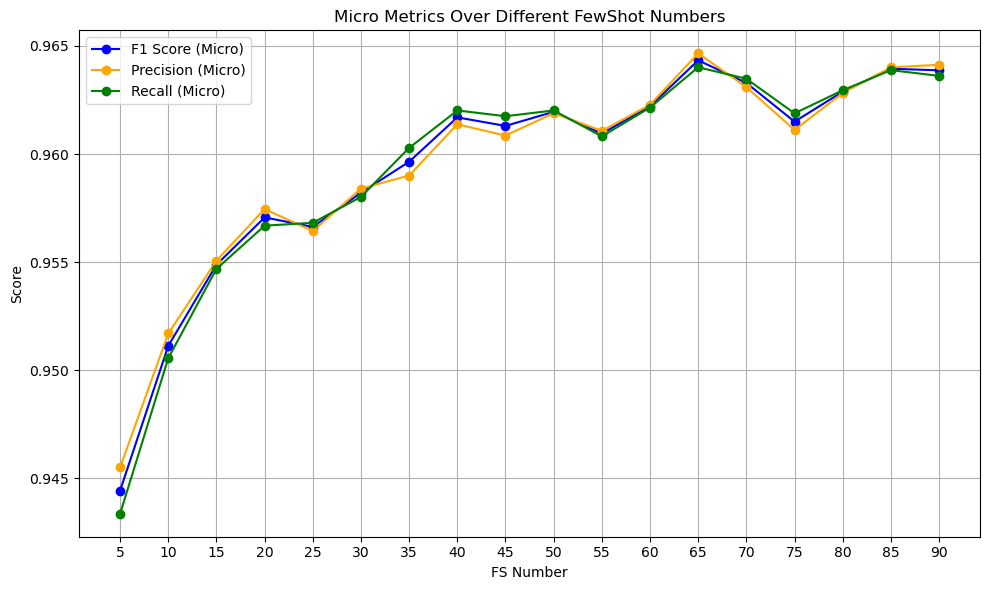

In [78]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(metrics_df2.index, metrics_df2['F1 Score (Micro)'], marker='o', label='F1 Score (Micro)', color='blue')
plt.plot(metrics_df2.index, metrics_df2['Precision (Micro)'], marker='o', label='Precision (Micro)', color='orange')
plt.plot(metrics_df2.index, metrics_df2['Recall (Micro)'], marker='o', label='Recall (Micro)', color='green')

# Adding labels and title
plt.title('Micro Metrics Over Different FewShot Numbers')
plt.xlabel('FS Number')
plt.ylabel('Score')
plt.xticks(metrics_df2.index)  # Set x-ticks to the index values
plt.grid()
plt.legend()
plt.tight_layout()

# Save plot as PNG
png_path = './micro_metrics_over_fewshot_numbers.png'
plt.savefig(png_path, format='png')
# Save plot as PDF
plt.savefig('micro_metrics_over_fewshot_numbers.pdf', format='pdf')


# Show the plot
plt.show()

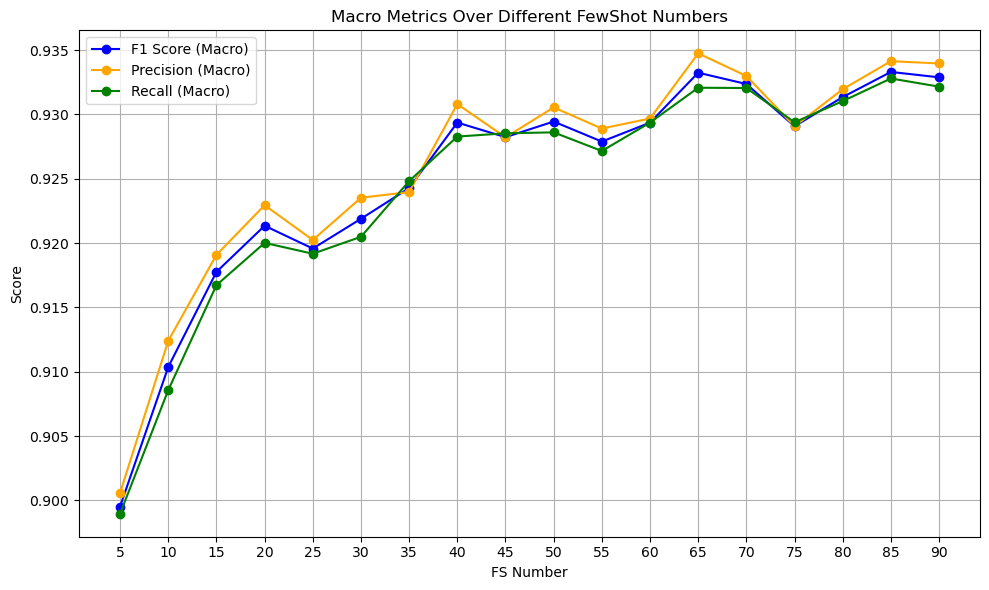

In [79]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(metrics_df2.index, metrics_df2['F1 Score (Macro)'], marker='o', label='F1 Score (Macro)', color='blue')
plt.plot(metrics_df2.index, metrics_df2['Precision (Macro)'], marker='o', label='Precision (Macro)', color='orange')
plt.plot(metrics_df2.index, metrics_df2['Recall (Macro)'], marker='o', label='Recall (Macro)', color='green')

# Adding labels and title
plt.title('Macro Metrics Over Different FewShot Numbers')
plt.xlabel('FS Number')
plt.ylabel('Score')
plt.xticks(metrics_df2.index)  # Set x-ticks to the index values
plt.grid()
plt.legend()
plt.tight_layout()

plt.savefig('macro_metrics_over_fewshot_numbers.pdf', format='pdf')

# Show the plot
plt.show()

In [84]:
metrics_df2.to_csv("./calibration_5-90_fs2.csv")

In [86]:
#metrics_df2